# Local to global N input modelling

In [ ]:
library(magrittr)
library(dplyr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'tidyr'

The following object is masked from 'package:magrittr':

    extract

here() starts at C:/Users/treimer/Documents/R-temp-files/local_to_global_mariculture_modelling


Attaching package: 'cowplot'

The following object is masked from 'package:ggpubr':

    get_legend


Attaching package: 'patchwork'

The following object is masked from 'package:cowplot':

    align_plots

qs 0.27.3. Announcement: https://github.com/qsbase/qs/issues/103


Attaching package: 'arrow'

The following object is masked from 'package:magrittr':

    is_in

The following object is masked from 'package:utils':

    timestamp

Linking to GEOS 3.13.0, GDAL 3.10.1, PROJ 9.5.1; sf_use_s2() is TRUE

terra 1.8.50


Attaching package: 'terra'

The following object is masked from 'package:arrow':

    buffer

The following object is masked from 'package:patchwork':

    area

The following object is masked from 'package:ggpubr':

    rotate

The following object is masked from 'package:tidyr':

    extract

The following objects are masked from 'package:magrittr':

    extract, inset


Attaching package: 'rnaturalearthdata'

The following object is masked from 'package:rnaturalearth':

    countries110

Loading required package: future


Attaching package: 'purrr'

The following object is masked from 'package:magrittr':

    set_names

udunits database from C:/Users/treimer/AppData/Local/R/cache/R/renv/cache/v5/windows/R-4.4/x86_64-w64-mingw32/units/0.8-7/5d0b024902d5da97a2b64f002e92a869/units/share/udunits/udunits2.xml

In [ ]:
source(here("00_model_functions.R"))

# Input paths
input_farm_coords_path <- here() %>% file.path("data", "_general_data", "farm_locations")
input_farm_sst_path <- here() %>% file.path("data", "_general_data", "SST")
input_species_param_path <- here() %>% file.path("data", "atlantic_salmon", "params")
input_feed_profile_path <- here() %>% file.path("data", "_general_data", "diets")

# Output paths
output_farm_data_path <- here() %>% file.path("outputs", "farm_data")
output_species_data_path <- here() %>% file.path("outputs", "species_data")
output_sens_data_path <- here() %>% file.path("outputs", "sensitivity_data")
output_farm_growth_data_path <- here() %>% file.path("outputs", "farm_growth_data")
output_cohort_growth_data_path <- here() %>% file.path("outputs", "cohort_growth_data")
data_analysis_path <- here() %>% file.path("outputs", "data_analysis")

# Filenames
farm_coords_file <- file.path(output_farm_data_path, "farm_coords.qs")
species_params_file <- file.path(output_species_data_path, "species_params.qs")
pop_params_file <- file.path(output_species_data_path, "pop_params.qs")
feed_params_file <- file.path(output_species_data_path, "feed_params.qs")
sens_params_file <- file.path(output_species_data_path, "sens_params.qs")
sens_results_files <- file.path(output_sens_data_path) %>% str_subset("results")

species_params <- qread(species_params_file)
pop_params <- qread(pop_params_file)

prettyplot <- function() {
  theme_classic() +
    theme(legend.position = "none",
          text = element_text(family = "serif", size = 12, colour = "black"),
          axis.title.x = element_text(vjust = 0.5),
          axis.title.y = element_text(hjust = 0.5))
}
  
feed_pal <- c("past" = "#E41A1C", "reference" = "#377EB8", "future" = "#4DAF4A")  
cohort_pal <- c("1" = "#E41A1C", "2" = "#377EB8", "3" = "#4DAF4A", "all" = "black")
macro_pal <- c(
  "protein" = "darkred", "P" = "darkred", 
  "carbohydrates" = "steelblue", "C" = "steelblue", 
  "lipids" = "darkgoldenrod1", "L" = "darkgoldenrod1"
)

In [ ]:
create_boxes <- function(box_list, label_positions, offset_deg) {
  boxes <- list()
  labels <- list()
  
  for(i in seq_along(box_list)) {
    name <- names(box_list)[i]
    coords <- box_list[[i]]
    pos <- label_positions[i]
    
    # Create polygon from bounding box coordinates
    box_coords <- matrix(c(
      coords[1], coords[3],  # lonmin, latmin
      coords[2], coords[3],  # lonmax, latmin  
      coords[2], coords[4],  # lonmax, latmax
      coords[1], coords[4],  # lonmin, latmax
      coords[1], coords[3]   # close polygon
    ), ncol = 2, byrow = TRUE)
    
    # Create sf polygon
    poly <- st_polygon(list(box_coords))
    boxes[[i]] <- st_sfc(poly, crs = 4326)
    
    # Calculate label position based on specification
    label_coords <- get_label_position(coords, pos, offset_deg[i])
    label_point <- st_point(c(label_coords[1], label_coords[2]))
    labels[[i]] <- st_sfc(label_point, crs = 4326)
  }
  
  # Combine into sf objects
  boxes_sf <- st_sf(
    name = names(box_list),
    letter = LETTERS[1:length(box_list)],
    geometry = do.call(c, boxes)
  )
  
  labels_sf <- st_sf(
    name = names(box_list), 
    letter = LETTERS[1:length(box_list)],
    geometry = do.call(c, labels)
  )
  
  return(list(boxes = boxes_sf, labels = labels_sf))
}

# Helper function to calculate label positions
get_label_position <- function(coords, position, offset) {
  lonmin <- coords[1]
  lonmax <- coords[2]
  latmin <- coords[3]
  latmax <- coords[4]
  
  # Parse position string
  parts <- strsplit(position, "_")[[1]]
  vertical <- parts[1]    # "top" or "bottom"
  horizontal <- parts[2]  # "left" or "right"
  location <- parts[3]    # "inside" or "outside"
  
  # Base coordinates for corners
  if(vertical == "bottom") {base_lat <- latmin} else {base_lat <- latmax}
  if(horizontal == "right") {base_lon <- lonmax} else {base_lon <- lonmin}

  # Apply offset for outside positioning
  if(location == "outside") {
    if(horizontal == "left") {base_lon <- base_lon-offset} else {base_lon <- base_lon+offset}
    if(vertical == "top") {base_lat <- base_lat + offset} else {base_lat <- base_lat - offset}
  }
  
  return(c(base_lon, base_lat))
}

lim_robin <- function(lons = c(144.0, 149.5), lats = c(-39.75, -44.00)) {
  coords <- data.frame(lon = lons, lat = lats) %>%
    st_as_sf(coords = c("lon", "lat"), crs = 4326) %>%
    st_transform(crs = "+proj=robin") %>% 
    st_coordinates()
  list(
    xlims = range(coords[, "X"]),
    ylims = range(coords[, "Y"])
  )
}

This document was last updated at 15:54 on 09 Jun, 2025.

# Methods

### Feeding rate

To detail here:

-   Functional response to temperature (species-specific)
-   Overfeeding parameters and how they come into play
-   Deminstration of how feeding response and actual food given vary with temperature?

In [ ]:
df <- data.frame(water_temp = seq(-5, 26, 0.25))
df$feeding <- sapply(FUN = feeding_rate, X = df$water_temp, species_params = species_params)
df <- df %>% 
mutate(ing_pot = pop_params['meanImax'] * (pop_params['meanW']^species_params['m']) * feeding,
       food_prov = NA)
for (i in 1:nrow(df)) {
  df$food_prov[i] <- food_prov_rate(pop_params = pop_params, rel_feeding = df$feeding[i], ing_pot = df$ing_pot[i], 
                                    ing_pot_10 = pop_params['meanImax'] * (pop_params['meanW']^species_params['m']) * 0.1)
}
df$ing_pot <- df$ing_pot/maxna(df$ing_pot)
df$food_prov <- df$food_prov/maxna(df$ing_pot)

df %>% 
  ggplot(aes(x = water_temp, y = ing_pot)) +
  geom_line(linewidth = 0.75) +
  geom_line(aes(y = food_prov), linewidth = 0.75, linetype = "dotted") +
  scale_y_continuous(breaks = seq(0,1.5,0.25)) +
  scale_x_continuous(breaks = seq(-5,30,5), limits = c(-5,26)) +
  labs(x = expression("Water temperature ("*degree*"C)"), y = "Relative food ingested/provided") +
  prettyplot() +
  theme(text = element_text(colour = "black", family = "serif", size = 12))

## Farm temperature forcings

In [ ]:
farms_to_omit <- file.path(input_farm_coords_path, "atlantic_salmon_farms_to_omit.qs") %>% qs::qread()
farm_ts_data <- file.path(output_farm_data_path, "farm_ts_data.qs") %>% qs::qread()
farm_coords <- file.path(output_farm_data_path, "farm_coords.qs") %>% qs::qread() %>% 
    mutate(hemisphere = case_when(lat < 0 ~ "S", T ~ "N") %>% as.factor()) 

farms_geometry <- file.path(output_farm_data_path, "farm_geometry.qs") %>% qs::qread() %>% 
  rename(farm_ID = farm_id)

sorted_countries <- farm_coords %>% 
  merge(farms_geometry, by = "farm_ID") %>% 
  group_by(country) %>% 
  reframe(av_lat = mean(lat)) %>% 
  arrange(-av_lat) %>% 
  pull(country) %>% 
  unique()

In [ ]:
farm_temp_means <- farm_ts_data %>% 
  group_by(farm_ID) %>% 
  reframe(mean_temp = mean(temp_c)) %>% 
  merge(farms_geometry, by = "farm_ID") %>% 
  merge(farm_coords, by = "farm_ID") %>% 
  dplyr::filter(!farm_ID %in% farms_to_omit)

overall_mean <- mean(farm_temp_means$mean_temp)
overall_sd <- sd(farm_temp_means$mean_temp)

rm(farm_ts_data)

Mean daily temperatures at the farms globally ranged from from 6$^{\circ}$C to 16.7$^{\circ}$C, with an overall mean of 10.1$^{\circ}$C ($\pm$ 1.8$^{\circ}$C SD). Farms with a mean temperature of \$$6$^\$C were excluded (4 farms). The total number of farms included in the analysis was therefore 2717.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

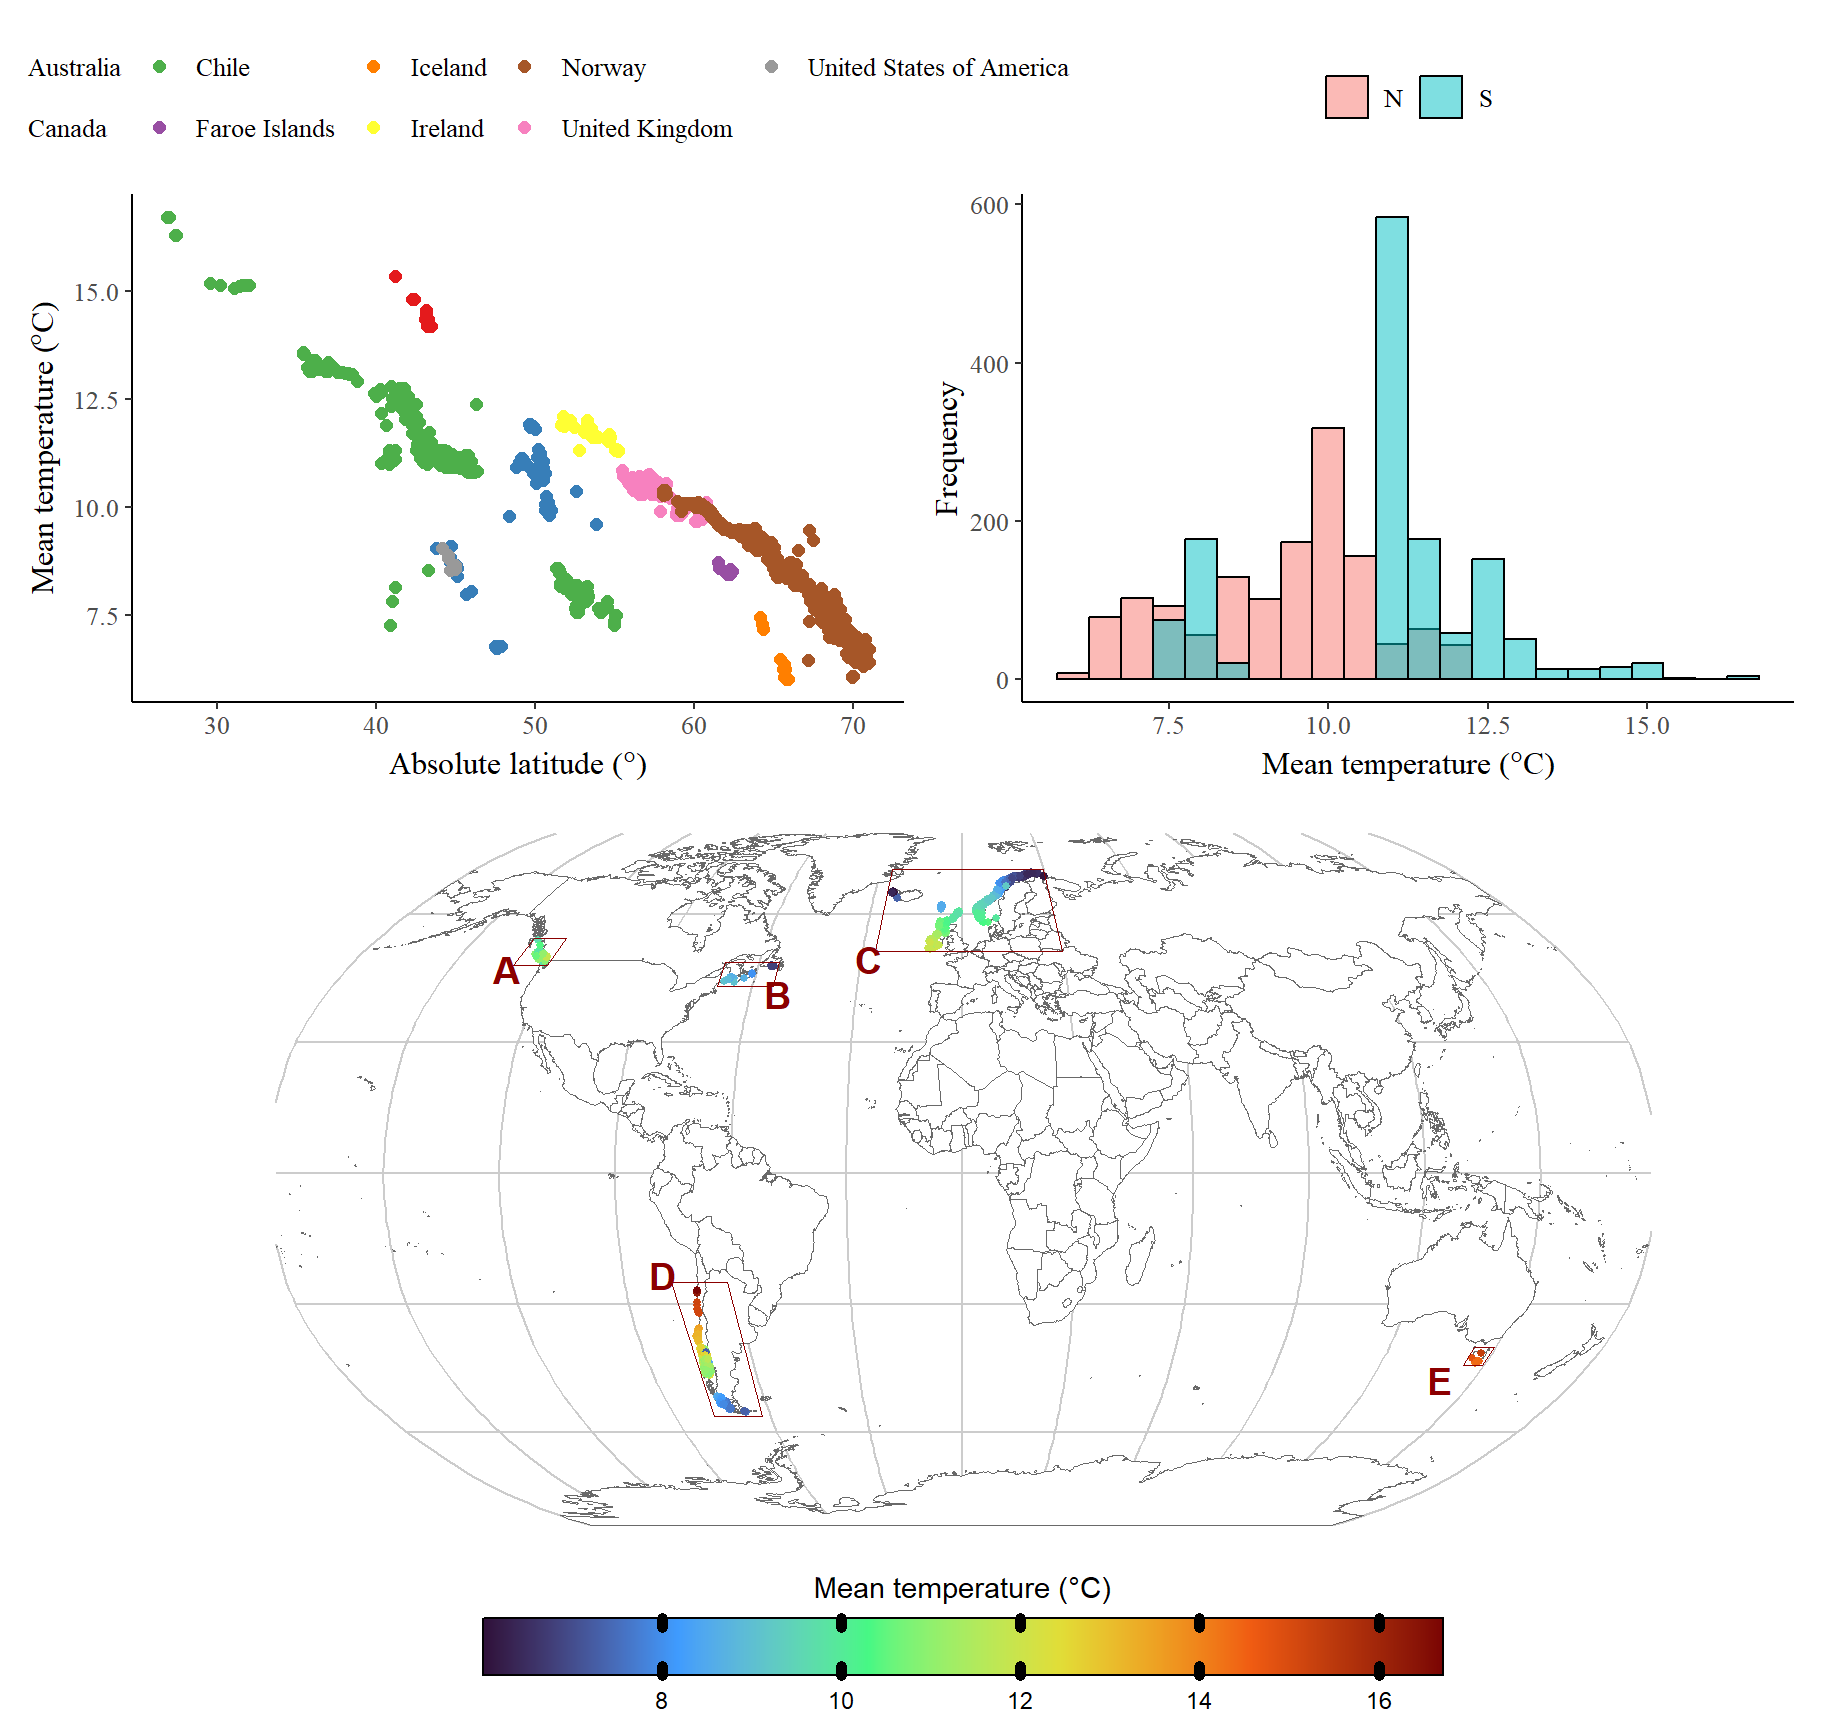

In [ ]:
worldmap <- ne_countries(scale = "medium", returnclass = "sf") %>% st_transform(crs = "+proj=robin")
graticules <- st_graticule(worldmap, lon = seq(-180, 180, 30), lat = seq(-90, 90, 30)) 

inset_boxes <- list(   # lonmin, lonmax, latmin, latmax
  CAN1 = c(-132, -122, 47.75, 54.25),
  CAN2 = c(-70, -54, 43, 48.5),
  EUR = c(-26, 30, 51, 72),
  CHI = c(-77.5, -62.5, -56, -25),
  AUS = c(144, 149.5, -44, -39.75)
)
labels_spec <- c(CAN1 = "bottom_left_outside", CAN2 = "bottom_right_outside", EUR = "bottom_left_outside", CHI = "top_left_outside", AUS = "bottom_left_outside")
labels_offset <- c(CAN1 = 1, CAN2 = 2, EUR = 1.75, CHI = 1.75, AUS = 3.5)

box_data <- create_boxes(box_list = inset_boxes, # see function create_boxes above
                         label_positions = unname(labels_spec),
                         offset_deg = unname(labels_offset))
boxes_robinson <- st_transform(box_data$boxes, crs = "+proj=robin")
labels_robinson <- st_transform(box_data$labels, crs = "+proj=robin")
farm_temp_robinson <- st_sf(farm_temp_means) %>% st_transform(crs = "+proj=robin")

p1 <- ggplot() +
  geom_sf(data = graticules, color = "gray80", size = 0.3) +
  geom_sf(data = worldmap, fill = "white", color = "dimgray") +
  geom_sf(data = farm_temp_robinson, aes(color = mean_temp), size = 1) +
  coord_sf() +
  scale_color_viridis_c(option = "turbo") +
  guides(col = guide_colourbar(
    title = "Mean temperature (°C)",
    direction = "horizontal", position = "bottom",
    label.position = "bottom", title.position = "top", 
    title.vjust = 1, title.hjust = 0.5,
    frame.colour = "black", ticks.colour = "black",ticks.linewidth = 2,
    barwidth = 25,barheight = 1.5
  )) +
  geom_sf(data = boxes_robinson, fill = NA, color = "darkred", size = 1.65) +
  geom_sf_text(data = labels_robinson, aes(label = letter), 
               color = "darkred", size = 5, fontface = "bold", 
               hjust = 0.5, vjust = 0.5) +
  theme_void()

In [ ]:
no_margins <- function() {
  theme(legend.position = "none", 
        plot.margin = margin(0, 0, 0, 0),
        axis.title = element_blank())
}

inset_boxes_sm <- list(   # lonmin, lonmax, latmin, latmax
  CAN1 = c(-132, -122, 48.5, 54),
  CAN2 = c(-70, -54, 43, 48.5),
  EUR = c(-23, 28.5, 52, 71),
  CHI = c(-78, -62, -55.5, -27),
  AUS = c(144, 149, -43.75, -40.75)
)

inset_boxes_sm <- map(inset_boxes_sm, function(bx) {
  list(
    xlims = bx[1:2],
    ylims = bx[3:4],
    labx = bx[1],
    laby = bx[4]
    )
})

worldmap <- ne_countries(scale = "large", returnclass = "sf")
p1 <- ggplot() +
  geom_sf(data = worldmap, fill = "white", color = "dimgray") +
  geom_sf(data = farm_temp_means, aes(color = mean_temp, geometry = geometry), size = 1) +
  coord_sf() +
  scale_color_viridis_c(option = "turbo") +
  guides(col = guide_colourbar(
    title = "Mean temperature (°C)",
    direction = "vertical", position = "right",
    label.position = "right", title.position = "top", 
    title.vjust = 1, title.hjust = 0.5,
    frame.colour = "black", ticks.colour = "black",ticks.linewidth = 2,
    barwidth = 1.5, barheight = 20
  )) +
  prettyplot() +
  labs(y = "Latitude", x = "Longitude")

p_Can1 <- p1 + 
  coord_sf(xlim = inset_boxes_sm[["CAN1"]][["xlims"]], 
           ylim = inset_boxes_sm[["CAN1"]][["ylims"]])  +
  draw_label("A", size = 14, fontface = "bold", 
             x = inset_boxes_sm[["CAN1"]][["labx"]], 
             y = inset_boxes_sm[["CAN1"]][["laby"]], 
             hjust = -1, vjust = 0.5)

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

## Production parameters

Salmon were grown for 548 days and were initialised Spring. This was on day 274 for farms in the southern hemisphere and day 121 for farms in the northern hemisphere. Cohorts were initialised anually, such that there was an overlap of 183 days where one cohort was nearing harvest and another was being initialised.

## Model parameterisation

In [ ]:
params <- file.path(output_species_data_path, "sens_params.qs") %>% qs::qread()

param_names <- tibble::tribble(
  ~name,        ~lab,
  "alpha",      bquote(alpha),
  "epsprot",    bquote(epsilon["P"]),
  "epslip",     bquote(epsilon["L"]),
  "epscarb",    bquote(epsilon["C"]),
  "epsO2",      bquote(epsilon["O"[2]]),
  "pk",         bquote("pk"),
  "k0",         bquote("k"[0]),
  "m",          bquote("m"),
  "n",          bquote("n"),
  "betac",      bquote(beta*"C"),
  "Tma",        bquote("T"["max"]),
  "Toa",        bquote("T"["opt"]),
  "Taa",        bquote("T"["min"]),
  "omega",      bquote(omega),
  "a",          bquote("a"),
  "k",          bquote("k"),
  "eff",        bquote("eff"),
  "meanW",      bquote(bar("W")),
  "deltaW",     bquote(Delta*"W"), 
  "meanImax",   bquote(bar("I"["max"])),
  "deltaImax",  bquote(Delta*"I"["max"]),
  "overFmean",  bquote(bar("F")),
  "overFdelta", bquote(Delta*"F"),
  "mortmyt",    bquote("mort")
)

@tbl-params shows the parameter values used to model the growth of farmed Atlantic salmon.

| Parameter | Value | Units | Description | Reference |
|:--:|:--:|:--:|:---|:---|
| $\alpha$ | 0.04 | \- | Feeding catabolism coefficient | *Salvelinus alpinus*, *Oncorhynchus mykiss* (temps: 8–13$^{\circ}$C) \[@broekhuizen_modelling_1994\] |
| $\epsilon_{P}$ | 2.36^{4} | J g$^{-1}$ | Energy content of protein | @baldan_r_2018 |
| $\epsilon_{L}$ | 3.62^{4} | J g$^{-1}$ | Energy content of lipid | @baldan_r_2018 |
| $\epsilon_{C}$ | 1.72^{4} | J g$^{-1}$ | Energy content of carbohydrate | @baldan_r_2018 |
| $\epsilon_{O_2}$ | 1.34^{4} | J g O$_2^{-1}$ | Energy consumed by the respiration of 1 g of oxygen | @elliott_energy_1975 |
| pk | 0.05 | d$^{-1}$ | Temperature coefficient for the fasting catabolism | @macnaughton_using_2019 |
| $k_0$ | 0.003 | \- | Fasting catabolism at 0 $^{^\circ}$C | @macnaughton_using_2019 |
| m | 0.75 | \- | Weight exponent for anabolism | Experimentally-derived alue over a range of *Oncorhynchus*, *Perca* and *Salmo* species (temps: 8–13$^{\circ}$C) \[@broekhuizen_modelling_1994\] |
| n | 1 | \- | Weight exponent for catabolism | @baldan_r_2018 |
| $\beta C$ | 0.3234 | \- | Shape coefficient for the feeding function | Fish size range: 2.25 $\pm$ 0.49 – 11.5 $\pm$ 5.29 g, temperature ranges: 5–24$\^{\circ}$C. Coefficient for mean daily energy intake of the moderately fast growing group, 0.4398 (mean fast group), 0.2214 (mean slow group) \[@jonsson_thermal_2001\] |
| $T_{max}$ | 26 | $^{\circ}$C | Maximum lethal temperature | Juvenile *Oncorhynchus tshawytscha* (19.8 $\pm$ 0.02 g, acclimation temp: 15$^{^\circ}$C, 19${\circ}$C) \[@poletto_unusual_2017\] |
| $T_{opt}$ | 16 | $^{\circ}$C | Optimal temperature | Fish size range: 2.25 $\pm$ 0.49 – 11.5 $\pm$ 5.29 g, temperature ranges: 5–24$^{^\circ}$C \[@jonsson_thermal_2001\]. Alt value: 14°C \[@handeland_effect_2008\], *Salmo salar* initial size: 77.0 $\pm$ 14.6 g, temps: 6, 10, 14, 18${\circ}$C |
| $T_{min}$ | 2 | $^{\circ}$C | Lowest feeding temperature | Fish essentially stop feeding when below 2$^{\circ}$C \[@vadboncoeur_lowering_2023\] |
| $\omega$ | 0.6542 | g O$_2$ g$^{-1}$ | Oxygen consumption:weight loss ratio | Calibrated value from @baldan_r_2018 |
| a | 2669 | J g tissue$^{-1}$ | Energy content of fish tissue | Alt value: 17.02350 (nls model fitted to female Atlantic salmon data extracted and transformed from @jonsson_energy_2003 \[@van_tien_development_2016\] |
| k | 0.1715 | \- | Weight exponent for energy content | Alt value: 1.65175 (nls model fitted to female Atlantic salmon data extracted and transformed from @jonsson_energy_2003 \[@van_tien_development_2016\] |
| eff | 0.97 | \- | Food ingestion efficiency | Range: 95-97% ingestion efficiency \[@uglem_does_2020\] |
| $\overline{W}$ | 125 | g | Dry weight mean | Range of 100-150 given so used a mean of 125 and sd of 10 which over 1000 draws from a normal distribution delivers a minimum and maximum close to these numbers \[@dempsey_estimating_2023\] |
| $\Delta{W}$ | 10 | g | Dry weight standard deviation | Range of 100-150 given so used a mean of 125 and sd of 10 which over 1000 draws from a normal distribution delivers a minimum and maximum close to these numbers \[@dempsey_estimating_2023\] |
| $\overline{I_{max}}$ | 0.035 | g g$^{-1}$ fish d$^{-1}$ | Ingestion rate mean | [FAO](https://www.fao.org/fileadmin/user_upload/affris/docs/tabl10.pdf) |
| $\Delta{I_{max}}$ | 0.005 | g g$^{-1}$ fish d$^{-1}$ | Ingestion rate standard deviation | [FAO](https://www.fao.org/fileadmin/user_upload/affris/docs/tabl10.pdf) |
| $\overline{F}$ | 0.015 | g g$^{-1}$ fish | Overfeeding rate mean |  |
| $\Delta{F}$ | 0.0045 | g g$^{-1}$ fish | Overfeeding rate standard deviation |  |
| mort | 5.99798^{-4} | d$^{-1}$ | Natural mortality rate | @tvete_towards_2023 |

### Parameter sensitivity

Parameter sensitivity was tested by varying each parameter in @tbl-params by $\pm 10$% and calculating sensitivity as $S_p = \frac{(P_{1.1} - P_{0.9})}{0.2 \times P_1}$, where $S$ is the sensitivity of the measured variable to changes in parameter $p$, and $P_{1.1}$, $P_{0.9}$, and $P_{1}$ are the value of the measured variable when the model is run with parameter $p$ at 110%, 90%, and 100% of its value respectively. All parameters in Table @tbl-params were tested. The population-level parameters ($\overline{W}$, $\Delta{W}$, $\overline{I_{max}}$, $\Delta{I_{max}}$, $\overline{F}$, $\Delta{F}$) were tested with a population of of 5000 on a random 10% of farms, while all other parameters were tested across all farms with a population of 10.

## Modelled experimental feeds

In [ ]:
feed_params <- file.path(output_species_data_path, "feed_params.qs") %>%
  qs::qread() 

feed_summary <- map_dfr(names(feed_params), function(feed) {
  df <- feed_params[[feed]]
  map_dfr(c("Proteins", "Lipids", "Carbohydrates"), function(macro) {
    contrib <- df[[macro]]$proportion * df[[macro]]$macro
    total <- sum(contrib)
    digest <- sum(df[[macro]]$digest * contrib) / total
        tibble(
      feed = feed,
      macro = macro,
      total = total,
      digest = digest
    )
  })
}) %>%
  mutate(macro = factor(macro, levels = c("Proteins", "Lipids", "Carbohydrates"), labels = c("P", "L", "C")),
         feed = factor(feed, levels = c("reference", "past", "future")),
         total_r = total * 100 %>% round(1),
         digest_r = digest * 100 %>% round(1))

Feeds came from \[@cottrell_origins_nodate; @cottrell_global_2020\].

<span class="column-margin margin-aside">Possibly replace this with a better summary of the ingredients that make up each feed, and report these stats in Results under Uneaten feed?</span>

The reference feed was 37.8% protein, 36.5% lipid, and 20.4% carbohydrate, the past feed was 49.8% protein, 27.1% lipid, and 16.6% carbohydrate, and the future feed was 47.7% protein, 32.9% lipid, and 13.9% carbohydrate.

Ingredients are tracked seperately through the model with their own digestibility coefficients. Overall, proteins within the reference feed were 89.2% digestible, proteins within the past feed were 90.5% digestible, and proteins within the future feed were 86.2% digestible. The digestibility of the other macronutrients are assumed to remain constant across all ingredients at 79.7% for carbohydrates and 96% for lipids.

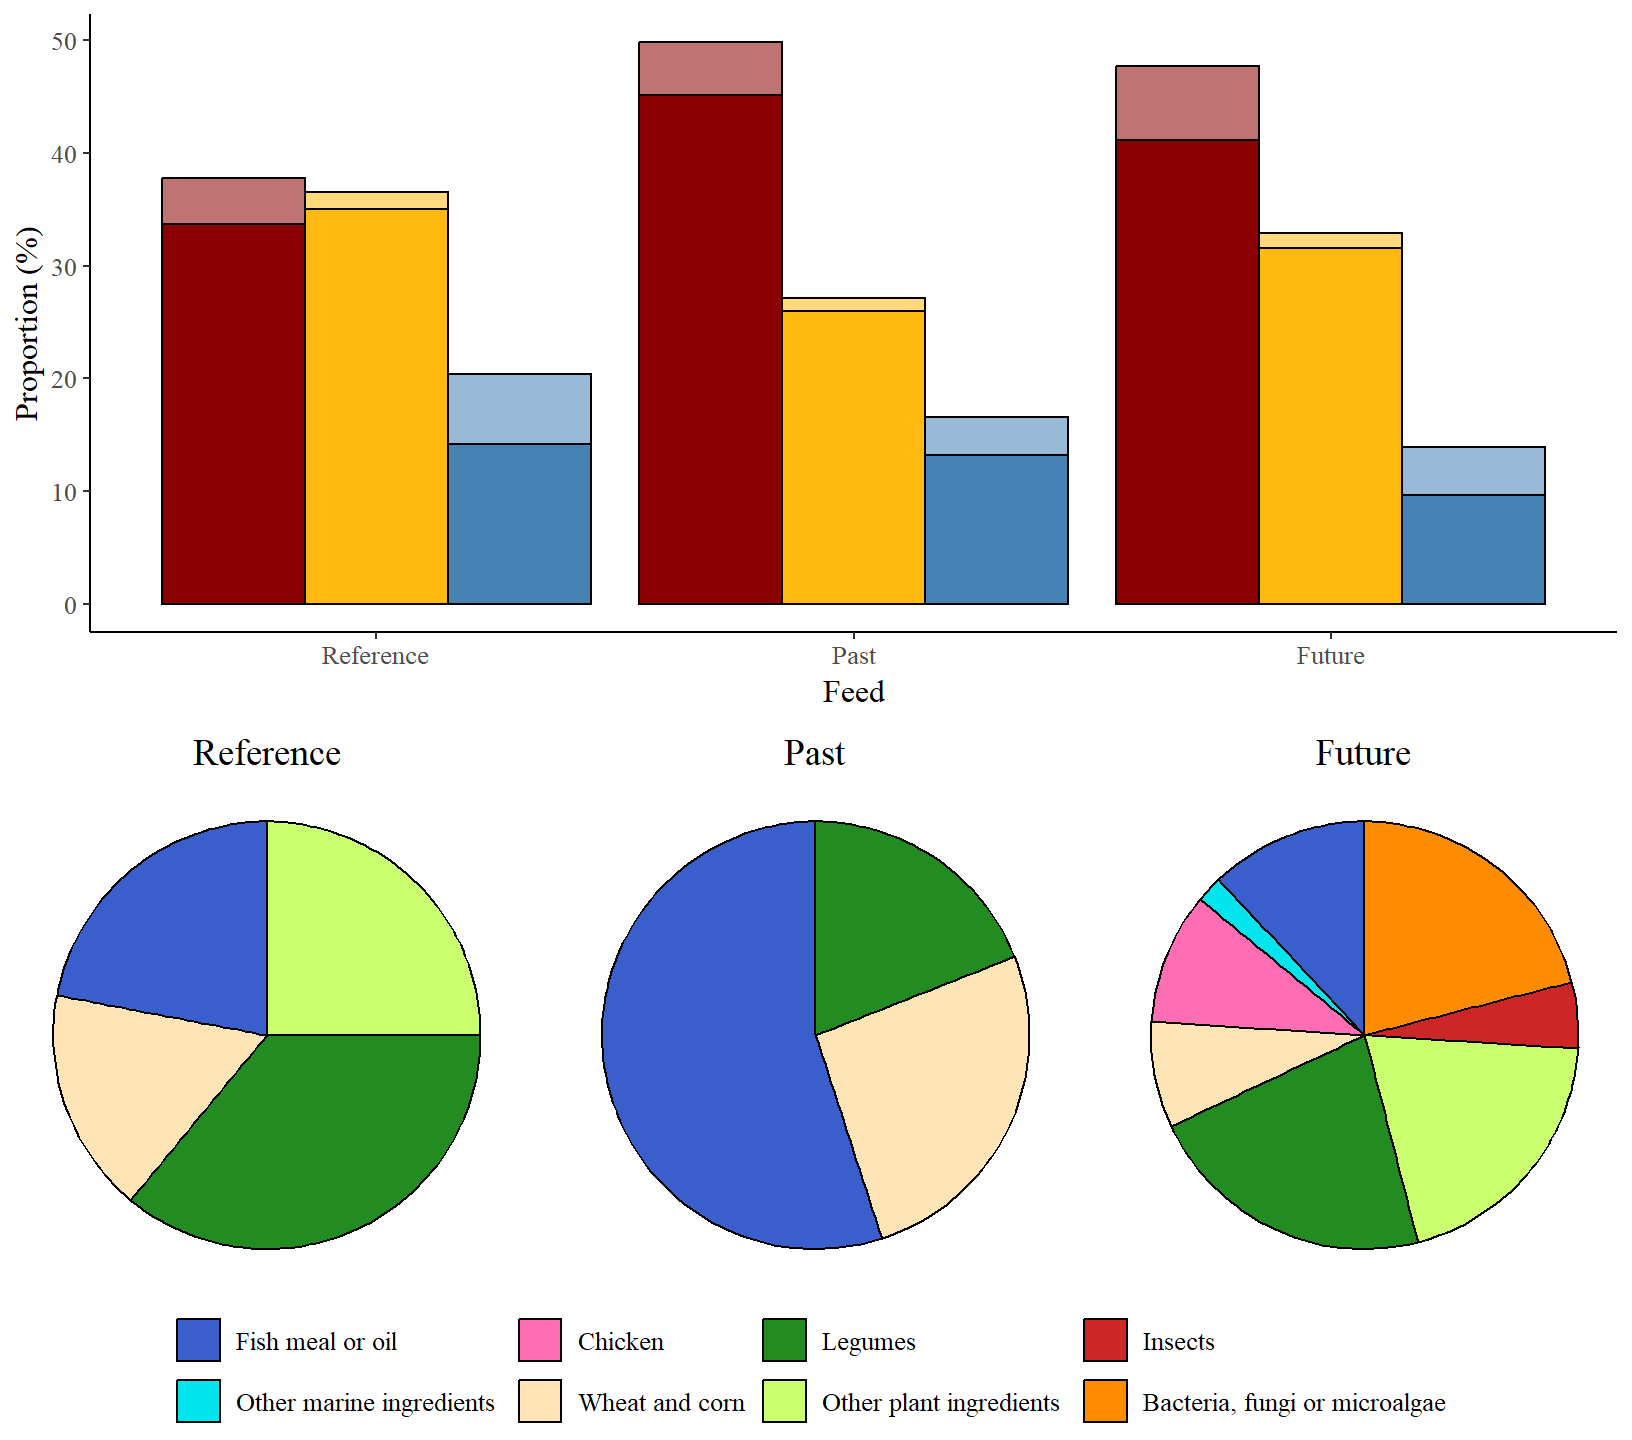

In [ ]:
p1 <- feed_summary %>%
  mutate(digest_total = digest * total) %>% 
  ggplot(aes(x = feed, y = total, fill = macro)) +
  geom_col(position = "dodge", alpha = 0.55, colour = "black") +
  geom_col(mapping = aes(y = digest_total), position = "dodge", alpha = 1, colour = "black") +
  scale_fill_manual(values = macro_pal) +
  scale_y_continuous(breaks = seq(0,0.5,0.1), labels = seq(0,50,10)) +
  scale_x_discrete(labels = c("reference" = "Reference", "past" = "Past", "future" = "Future")) +
  labs(x = "Feed", y = "Proportion (%)") +
  prettyplot()

feed_ings <- rbind(
  feed_params[[1]][[1]] %>% mutate(feed = as.factor("reference")), 
  feed_params[[2]][[1]] %>% mutate(feed = as.factor("past")), 
  feed_params[[3]][[1]] %>% mutate(feed = as.factor("future"))
) %>%
  rename(protein = macro) %>%
  mutate(
    category = case_when(
      str_detect(ingredient, "fish-oil") ~ "fish",
      str_detect(ingredient, "fishmeal") ~ "fish",
      str_detect(ingredient, "krill") ~ "other-marine",
      str_detect(ingredient, "soy") ~ "legume",
      str_detect(ingredient, "pea") ~ "legume",
      str_detect(ingredient, "guar") ~ "legume",
      str_detect(ingredient, "faba") ~ "legume",
      str_detect(ingredient, "corn") ~ "wheat-corn",
      str_detect(ingredient, "wheat") ~ "wheat-corn",
      str_detect(ingredient, "chicken") ~ "chicken",
      str_detect(ingredient, "bacteri") ~ "bact-fungi-micro",
      str_detect(ingredient, "yeast") ~ "bact-fungi-micro",
      str_detect(ingredient, "spirulina") ~ "bact-fungi-micro",
      str_detect(ingredient, "bsf") ~ "insect",
      T ~ "other-plant"
    ) %>% 
      factor(levels = c("fish", "other-marine", "chicken", "wheat-corn", "legume", "other-plant", "insect", "bact-fungi-micro"))
  )

p_ings <- feed_ings %>% 
  mutate(feed = factor(feed, levels = c("reference", "past", "future"), labels = c("Reference", "Past", "Future"))) %>% 
  group_by(feed, category) %>%
  reframe(proportion = sum(proportion)) %>% 
  ggplot(aes(x = "", y = proportion, fill = category)) +
  geom_col(width = 1, colour = "black") +
  coord_polar("y", start = 0) +
  scale_fill_manual(
    name = "Ingredient category",
    values = c("fish" = "royalblue3", "other-marine" = "turquoise2", "chicken" = "hotpink1", "wheat-corn" = "moccasin", "legume" = "forestgreen", "other-plant" = "darkolivegreen1", "insect" = "firebrick3", "bact-fungi-micro" = "darkorange"), 
    labels = c("Fish meal or oil", "Other marine ingredients", "Chicken", "Wheat and corn", "Legumes", "Other plant ingredients", "Insects", "Bacteria, fungi or microalgae")) +
  facet_grid(cols = vars(feed)) +
  theme_void() +
  theme(
    text = element_text(family = "serif", size = 12, colour = "black"),
    legend.position = "bottom",
    legend.title = element_blank(), 
    strip.text = element_blank(),
    strip.text.x = element_text(size = 14)
  )

plot_grid(p1, p_ings, nrow = 2)

## Model population and biomass

In [ ]:
farmrun_files <- file.path(output_cohort_growth_data_path) %>% 
  list.files(full.names = T)

weight <- purrr::map(farmrun_files, function(f) {qs::qread(f)[["weight_stat"]]}) %>%
  bind_rows()
biomass <- purrr::map(farmrun_files, function(f) {qs::qread(f)[["biomass_stat"]]}) %>%
  bind_rows()

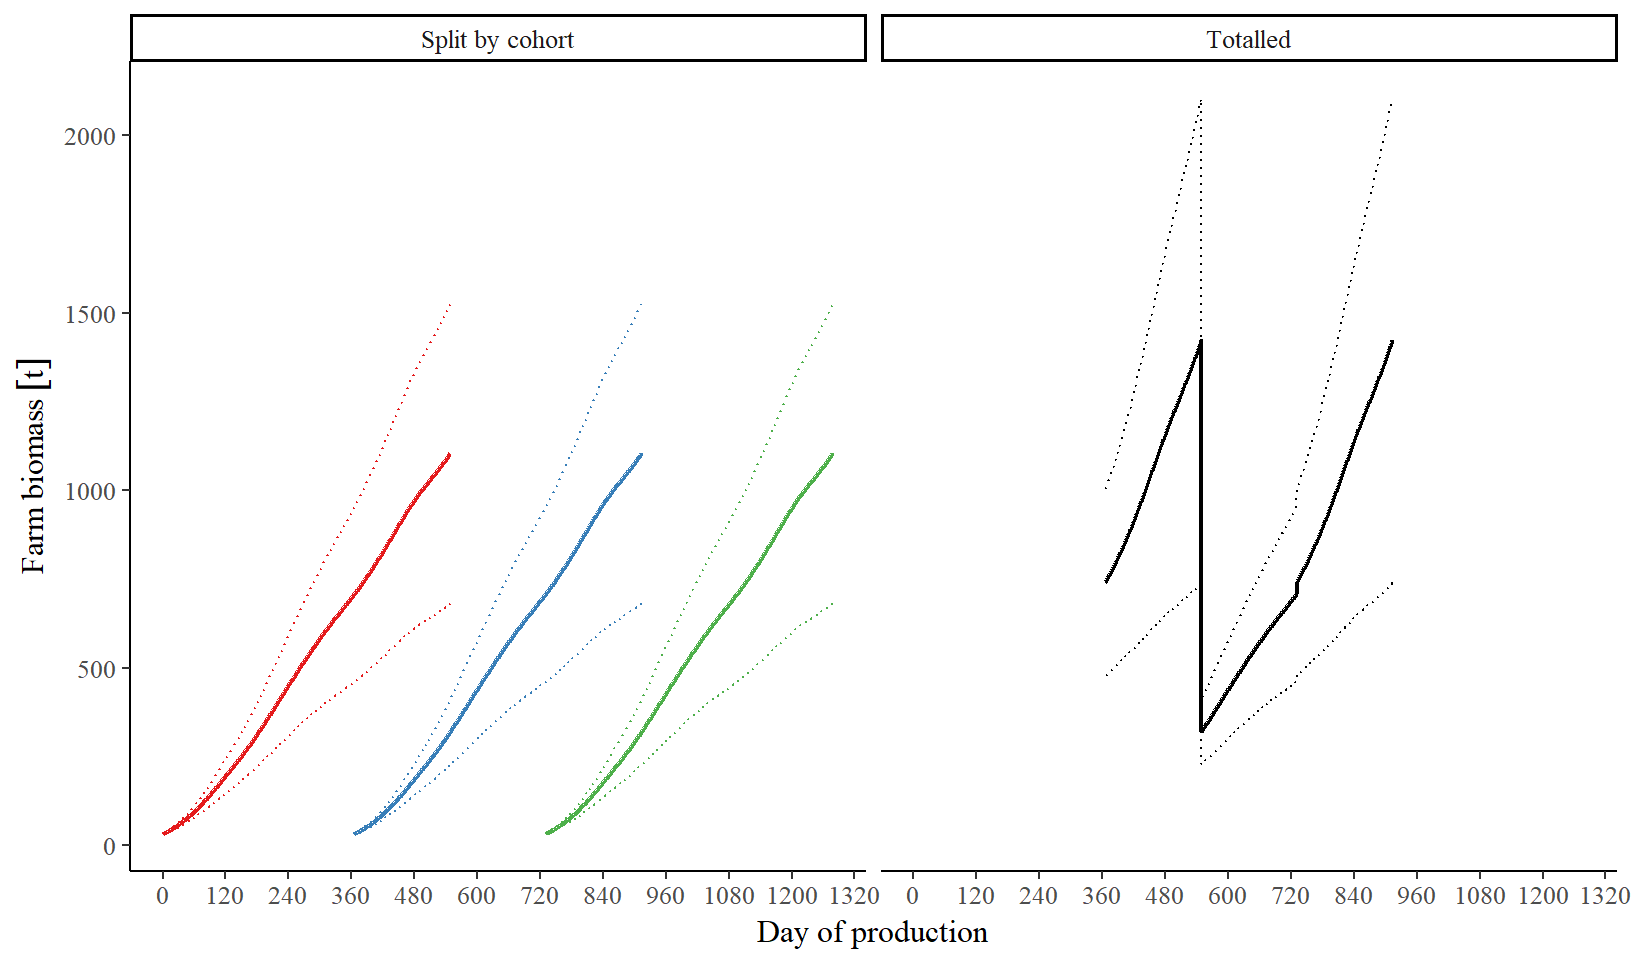

In [ ]:
fnms <- output_farm_growth_data_path %>% 
  list.files(full.names = T) %>% 
  str_subset("reference")

df <- qs::qread(fnms[1])[["biomass_stat"]] %>% 
  as.data.frame() %>% 
  mutate(mean = set_units(mean, "g") %>% set_units("t"),
         sd = set_units(sd, "g") %>% set_units("t")) %>% 
  select(-farm_ID)

df <- rbind(
  df %>% mutate(cohort = 1),
  df %>% mutate(t = t+365, cohort = 2),
  df %>% mutate(t = t+730, cohort = 3)
) %>% 
  mutate(t = (t-min(t))+1,
         split = "Split by cohort")

min_t <- min(df$t[df$cohort == 2])
max_t <- max(df$t[df$cohort == 2])

df_2 <- df %>% 
  filter(t %in% min_t:max_t) %>% 
  mutate(sd = sd/mean) %>% 
  group_by(t) %>% 
  reframe(sd = sqrt(sum(sd^2)),
          mean = sum(mean),
          sd = sd*mean) %>% 
  mutate(cohort = "all",
         split = "Totalled")

df <- rbind(df, df_2) %>% 
  mutate(cohort = as.factor(cohort))

ggplot(df, aes(x = t, y = mean, ymin = mean-sd, ymax = mean+sd, colour = as.factor(cohort))) +
  geom_line(linewidth = 0.75) +
  geom_ribbon(linetype = "dotted", alpha = 0) +
  facet_grid(cols = vars(split)) +
  scale_x_continuous(breaks = seq(0, 1600, 120)) +
  scale_colour_manual(values = cohort_pal) +
  prettyplot() +
  labs(y = "Farm biomass", x = "Day of production")

In [ ]:
coho_biom <- file.path(data_analysis_path, "biomass_produced_comparison.qs") %>% 
  qs::qread()
harv_size <- file.path(output_farm_data_path, "farm_harvest_size.qs") %>% 
  qread()

coho_biom_summ <- coho_biom %>% 
  mutate(perc_diff = 100*(mean - tonnes_per_farm)/tonnes_per_farm)

Each farm’s final population was calculated by dividing the production tonnage required by the average modelled individual harvest size for each farm (when feed reference feed). A population timeseries was the generated using the standard mortality rate (5.99798^{-4} d$^{-1}$). Using this method, a farm’s ‘population’ is not a good representation of the actual number of individuals being farmed, but it ensures each farm location is producing the correct tonnage while allowing comparisons between the different feeds.

By this method, farm biomass as predicted by the model slightly overestimated farm tonnage. Predicted farm biomass was 2.4-6.5 higher than tonnage produced (@fig-biomass-produced). This variation was not correlated with mean farm temperature or total tonnage produced (@fig-biomass-variation).

## Impacts of nutrient input

*To detail here:*

-   How to convert feed and uneaten faeces into nutrients - just nitrogen? Carbon too? If just nitrogen, then can probably use the standard N = 6.25 x protein conversion to compare the feeds (lipids and carbohydrates have negligible protein). If doing carbon too, will need to find conversion rates for all of them, possibly splitting carbs/lipids into complex/simple, saturated/unsaturated, etc.
-   Source of species vulnerability layers

# Results

-   Parameter sensitivity results are in supplementary @sec-parameter-sensitivity

In general, data outputs comes in the following dimensions:

-   Location -\> temperature -\> farm_ID
-   Uneaten feed + excreted faeces = total inputs (g)
-   Day of production (impacted by location)
-   Main point is the difference between feeds (kg/t salmon).
-   Also interesting to see if difference between feeds varies geographically (correlates with latitude, or maybe mean/median/max temperature?)

## Uneaten feed

In [ ]:
uneaten_total <- farmrun_files %>% 
  purrr::map(function(f) {qs::qread(f)[["total_uneat_stat"]]}) %>% 
  bind_rows() %>% 
  merge(biomass, by = c("farm_ID", "feed", "t")) %>% 
  rename(uneat_mean = mean.x, biomass_mean = mean.y,
         uneat_sd = sd.x, biomass_sd = sd.y) %>% 
  mutate(uneat_sd = uneat_sd/uneat_mean,
         biomass_sd = biomass_sd/biomass_mean,
         uneat_biom_mean = uneat_mean/biomass_mean,
         uneat_biom_sd = sqrt(uneat_sd^2+biomass_sd^2)*uneat_biom_mean)

In [ ]:
uneaten_total_stats <- uneaten_total %>% 
  group_by(feed, farm_ID) %>% 
  reframe(total = sum(uneat_biom_mean)) %>% 
  group_by(feed) %>% 
  reframe(min = minna(total),
          max = maxna(total),
          mean = meanna(total)) %>% 
  mutate(min = min %>% set_units("g g_fish-1") %>% set_units("g kg_fish-1"),
         max = max %>% set_units("g g_fish-1") %>% set_units("g kg_fish-1"),
         mean = mean %>% set_units("g g_fish-1") %>% set_units("g kg_fish-1")) %>% 
  mutate(min = round(min,2),
         max = round(max,2),
         mean = round(mean,2))

uneaten_total_compare <- uneaten_total %>% 
  group_by(feed, farm_ID) %>% 
  reframe(total = sum(uneat_biom_mean)) %>% 
  pivot_wider(names_from = "feed", values_from = "total", id_cols = "farm_ID") %>% 
  mutate(diff_past = past-reference,
         diff_future = future-reference,
         diffperc_past = diff_past/reference,
         diffperc_future = diff_future/reference) %>% 
  dplyr::select(-c(reference, future, past)) %>% 
  pivot_longer(names_to = c("measure", "feed"), names_sep = "_", values_to = "value",
               cols = contains("diff"), names_transform = list(measure = as.factor, feed = as.factor)) %>% 
  group_by(feed, measure) %>% 
  reframe(min = minna(value),
          max = maxna(value),
          mean = meanna(value)) %>% 
  mutate(
    min = case_when(measure == "diffperc" ~ 100*min,
                    T ~ min %>% set_units("g g_fish-1") %>% set_units("g kg_fish-1") %>% drop_units()),
    max = case_when(measure == "diffperc" ~ 100*max,
                    T ~ max %>% set_units("g g_fish-1") %>% set_units("g kg_fish-1") %>% drop_units()),
    mean = case_when(measure == "diffperc" ~ 100*mean,
                     T ~ mean %>% set_units("g g_fish-1") %>% set_units("g kg_fish-1") %>% drop_units()),
    )

Total uneaten feed across a cohort (548 days) fed the reference feed ranged from 48.46 to 73.82 g kg$^{-1}$ fish, with a mean of 61.71 g kg$^{-1}$ fish.

-   Differences between the feeds were very small, with the past scenario producing
-   but slightly less uneaten feed was lost in the reference scenario. Uneaten past feed ranged from 48.72 to 48.72 g kg$^{-1}$ (mean of 62.17) while uneaten future feed ranged from 48.73 to 48.73 g kg$^{-1}$ (mean of 62.05).
-   @fig-total-uneaten-perday shows the range of total uneaten feed per day across countries.

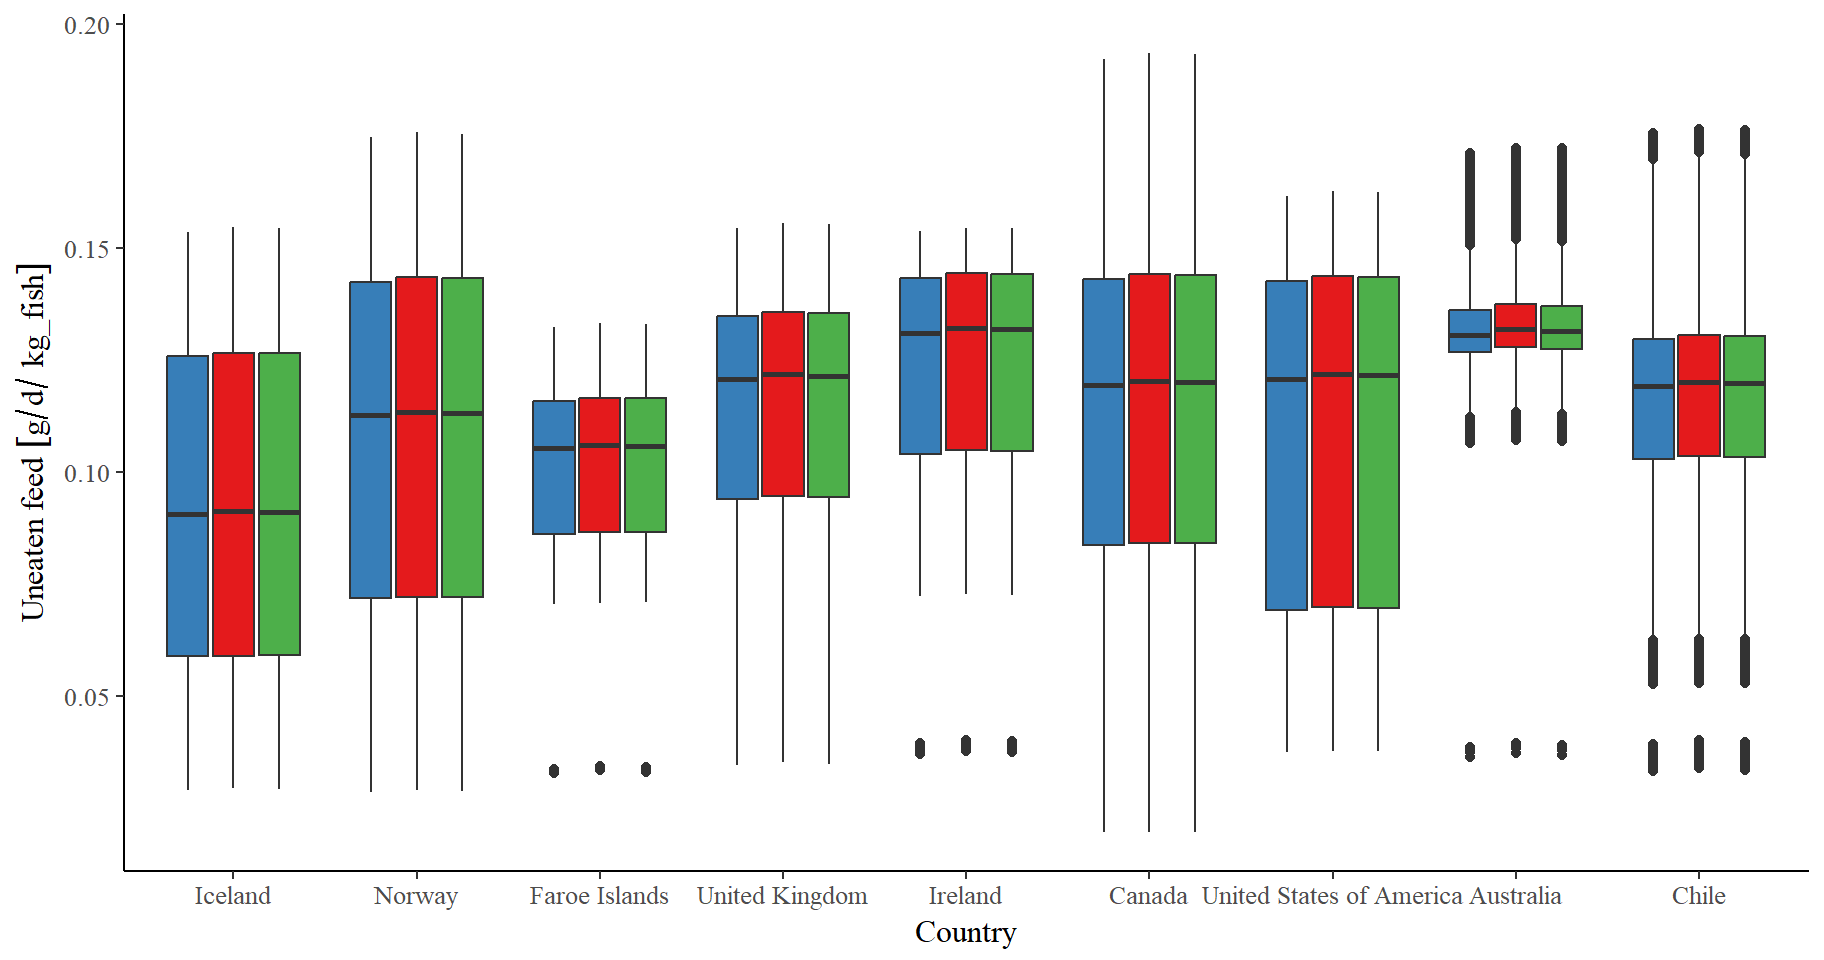

In [ ]:
uneaten_total %>% 
  merge(farms_geometry, by = "farm_ID") %>% 
  mutate(uneat_biom_mean = uneat_biom_mean %>% set_units("g g_fish-1 d-1") %>% set_units("g kg_fish-1 d-1"),
         country = factor(country, levels = sorted_countries)) %>% 
  ggplot(aes(x = country, y = uneat_biom_mean, fill = feed)) +
  geom_boxplot() +
  prettyplot() +
  scale_fill_manual(values = feed_pal) +
  labs(y = "Uneaten feed", x = "Country")

In [ ]:
uneaten_P <- farmrun_files %>% purrr::map(function(f) {qs::qread(f)[["P_uneat_stat"]]}) %>% bind_rows()
uneaten_L <- farmrun_files %>% purrr::map(function(f) {qs::qread(f)[["L_uneat_stat"]]}) %>% bind_rows()
uneaten_C <- farmrun_files %>% purrr::map(function(f) {qs::qread(f)[["C_uneat_stat"]]}) %>% bind_rows()

uneaten_all <- uneaten_total %>% 
  select(-contains("biom")) %>% 
  merge(uneaten_P, by = c("farm_ID", "feed", "t")) %>% 
  merge(uneaten_L, by = c("farm_ID", "feed", "t")) %>% 
  merge(uneaten_C, by = c("farm_ID", "feed", "t")) %>% 
  select(-c(contains("sd")))

-   The composition of the uneaten feed is (obviously) the same as the total feed composition (@sec-feeds).

## Excreted faeces

In [ ]:
# The following reads in all the total excretion data and converts the mean and sd values into values/biomass
excreted_total <- farmrun_files %>% 
  purrr::map(function(f) {qs::qread(f)[["total_excr_stat"]]}) %>% 
  bind_rows() %>% 
  merge(biomass, by = c("farm_ID", "feed", "t")) %>% 
  rename(excr_mean = mean.x, biomass_mean = mean.y,
         excr_sd = sd.x, biomass_sd = sd.y) %>% 
  mutate(excr_sd = excr_sd/excr_mean,
         biomass_sd = biomass_sd/biomass_mean,
         excr_biom_mean = excr_mean/biomass_mean,
         excr_biom_sd = sqrt(excr_sd^2+biomass_sd^2)*excr_biom_mean)

excreted_total_stats <- excreted_total %>% 
  group_by(feed, farm_ID) %>% 
  reframe(total = sum(excr_biom_mean)) %>% 
  group_by(feed) %>% 
  reframe(min = minna(total),
          max = maxna(total),
          mean = meanna(total)) %>% 
  mutate(min = min %>% set_units("g g_fish-1") %>% set_units("g kg_fish-1"),
         max = max %>% set_units("g g_fish-1") %>% set_units("g kg_fish-1"),
         mean = mean %>% set_units("g g_fish-1") %>% set_units("g kg_fish-1")) %>% 
  mutate(min = round(min,2),
         max = round(max,2),
         mean = round(mean,2))

### Amount

-   Total reference excreted faeces across a cohort (548 days) ranged from 194.24 to 295.9 g kg$^{-1}$, with a mean of 247.38.
-   There was very little difference between the past and future feeds and the reference feed. Uneaten past feed ranged from 154.33 to 236.05 g kg$^{-1}$ (mean of 196.94 g kg$^{-1}$) while uneaten future feed ranged from 202.55 to 308.61 g kg$^{-1}$ (mean of 257.91 g kg$^{-1}$).
-   @fig-total-excreted-perday shows the range of total excreted faeces per day across countries.

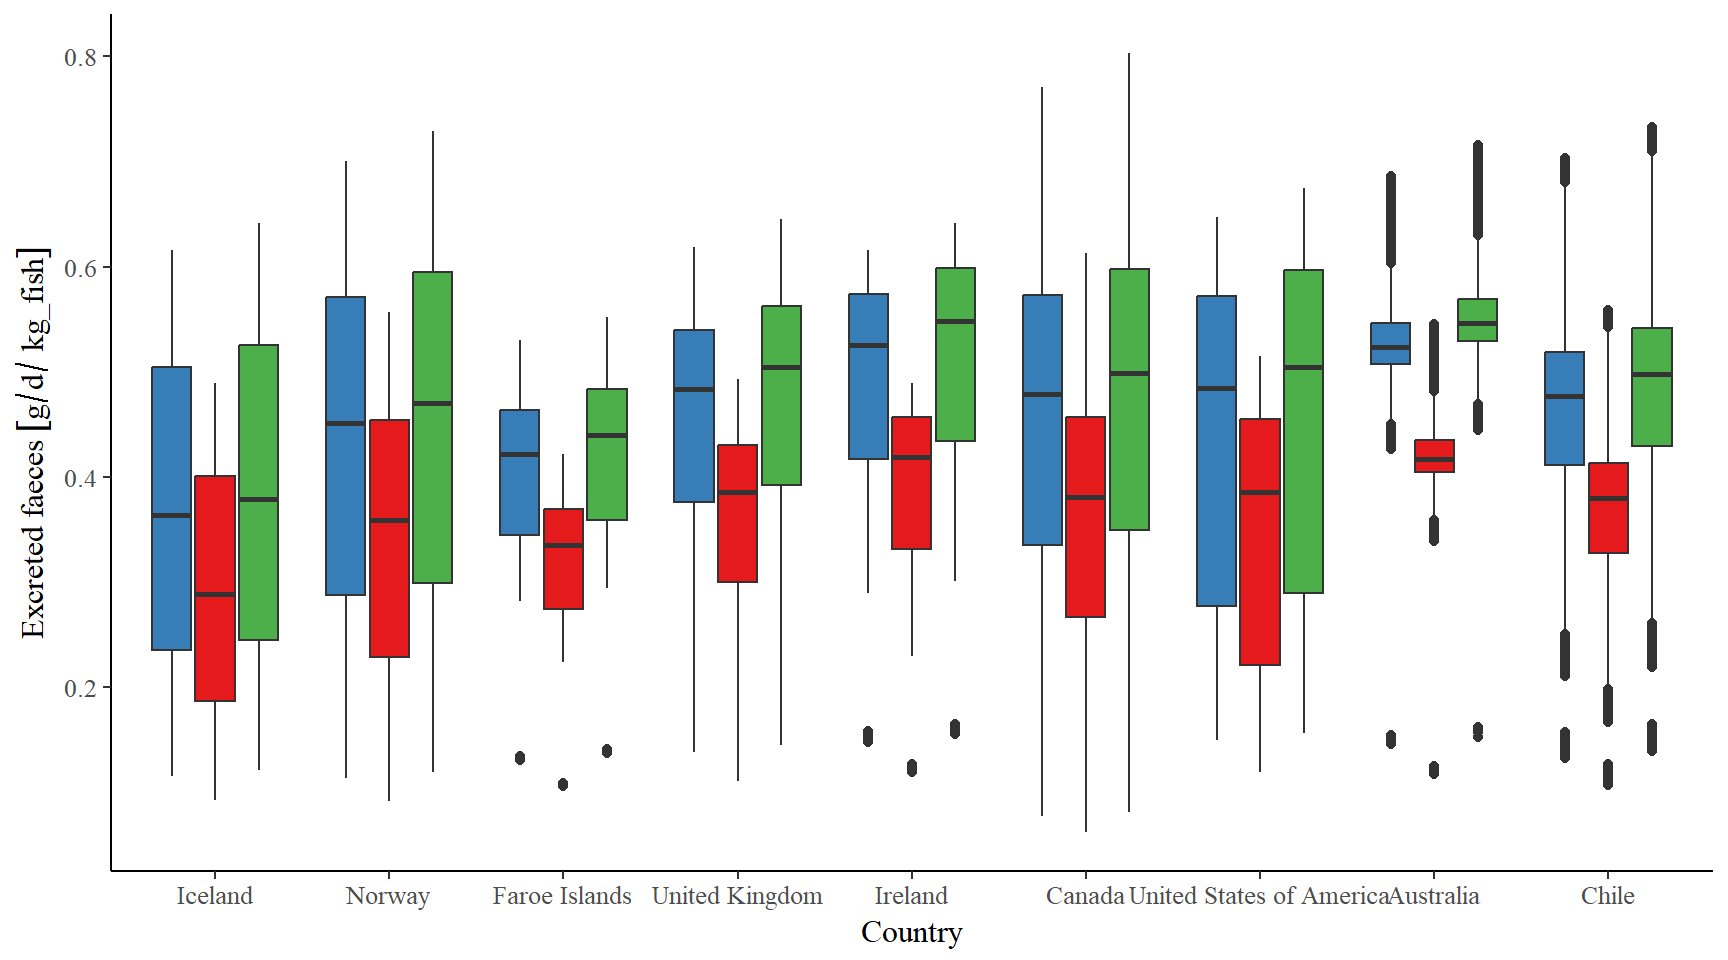

In [ ]:
excreted_total %>% 
  merge(farms_geometry, by = "farm_ID") %>% 
  mutate(excr_biom_mean = excr_biom_mean %>% set_units("g g_fish-1 d-1") %>% set_units("g kg_fish-1 d-1"),
         country = factor(country, levels = sorted_countries)) %>% 
  ggplot(aes(x = country, y = excr_biom_mean, fill = feed)) +
  geom_boxplot() +
  prettyplot() +
  scale_fill_manual(values = feed_pal) +
  labs(y = "Excreted faeces", x = "Country")

The difference in total excretion for the past feed ranged from -26, -26.1–23.9, -23.9% across all farms globally, and for the future feed ranged from 1.3, 1.3-4.1, 3.7%.

However, the actual difference in excreted faeces varied by feed, time in the production cycle, and location of the farm \[@fig-total-excr-act_diff\].

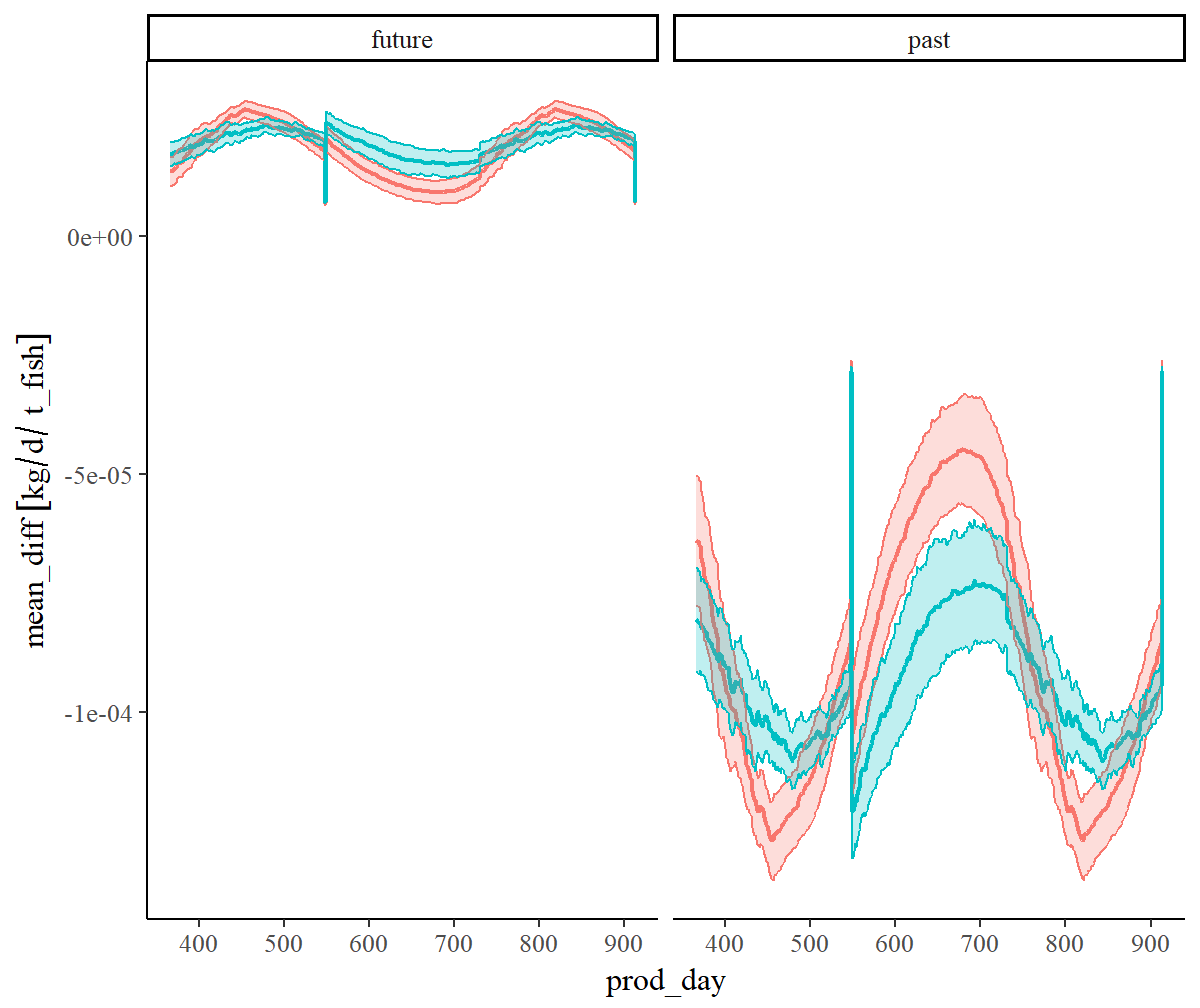

In [ ]:
df <- excreted_total %>% 
  select(-contains(c("sd", "excr_mean", "biomass"))) %>% 
  pivot_wider(names_from = "feed", values_from = "excr_biom_mean") %>% 
  mutate(past = past-reference,
         future = future-reference) %>% 
  pivot_longer(names_to = "feed", values_to = "diff", cols = c(past, future), names_transform = list(feed = as.factor)) %>% 
  mutate(reference = set_units(reference, "g kg_fish-1 d-1"),
         diff = set_units(diff, "kg t_fish-1 d-1")) %>% 
  merge(farm_coords, by = "farm_ID") %>% 
  mutate(prod_day = t-t_start+1)

summ <- df %>%
  group_by(hemisphere, feed) %>% 
  reframe(mean = meanna(diff) %>% round(3),
          min = meanna(diff) %>% round(3),
          max = maxna(diff) %>% round(3))

df %>% 
  group_by(hemisphere, feed, prod_day) %>% 
  reframe(mean_diff = meanna(diff),
          sd_diff = sdna(diff) %>% set_units("kg t_fish-1 d-1")) %>% 
  ggplot(aes(x = prod_day, y = mean_diff, ymin = mean_diff-sd_diff, ymax = mean_diff+sd_diff, colour = hemisphere, fill = hemisphere)) +
  geom_line(linewidth = 0.75) +
  geom_ribbon(alpha = 0.25) +
  facet_wrap(~feed) +
  prettyplot()

### Composition

In [ ]:
excreted_P <- farmrun_files %>% purrr::map(function(f) {qs::qread(f)[["P_excr_stat"]]}) %>% bind_rows()
excreted_L <- farmrun_files %>% purrr::map(function(f) {qs::qread(f)[["L_excr_stat"]]}) %>% bind_rows()
excreted_C <- farmrun_files %>% purrr::map(function(f) {qs::qread(f)[["C_excr_stat"]]}) %>% bind_rows()

excreted_all <- excreted_total %>% 
  select(-contains("biom")) %>% 
  merge(excreted_P, by = c("farm_ID", "feed", "t")) %>% 
  merge(excreted_L, by = c("farm_ID", "feed", "t")) %>% 
  merge(excreted_C, by = c("farm_ID", "feed", "t")) %>% 
  select(-c(contains("sd"))) %>% 
  rename(protein = mean.x, lipids = mean.y, carbohydrates = mean) %>% 
  mutate(protein = protein/excr_mean %>% set_units("d-1"),
         lipids = lipids/excr_mean %>% set_units("d-1"),
         carbohydrates = carbohydrates/excr_mean %>% set_units("d-1")) %>% 
  select(-excr_mean)

ec <- excreted_all %>% 
  group_by(feed) %>% 
  reframe(P = mean(protein),
          C = mean(carbohydrates),
          L = mean(lipids)) %>% 
  mutate(source = "excreted") %>% 
  rbind(data.frame(
    feed = c("reference", "past", "future"),
    P = c(tP_1, tP_2, tP_3),
    C = c(tC_1, tC_2, tC_3),
    L = c(tL_1, tL_2, tL_3),
    source = rep("feed", 3)
  )) %>% 
  pivot_longer(cols = c(P,L,C), names_to = "macro", values_to = "value", 
               names_transform = list(macro = as.factor), values_transform = list(value = as.numeric)) %>% 
  mutate(source = factor(source, levels = c("feed", "excreted")),
         macro = factor(macro, levels = c("P", "L", "C"), labels = c("Protein", "Lipids", "Carbohydrates")),
         feed = factor(feed, levels = c("reference", "past", "future")),
         source = factor(source, levels = c("feed", "excreted"), labels = c("Feed", "Faeces")))

Unlike the uneaten feed, the composition of excreted faeces differs from that of the incoming feed. <span class="column-margin margin-aside">Note that composition does not change through time or with increasing biomass (because digestibility does not change with fish size or temeprature)</span>

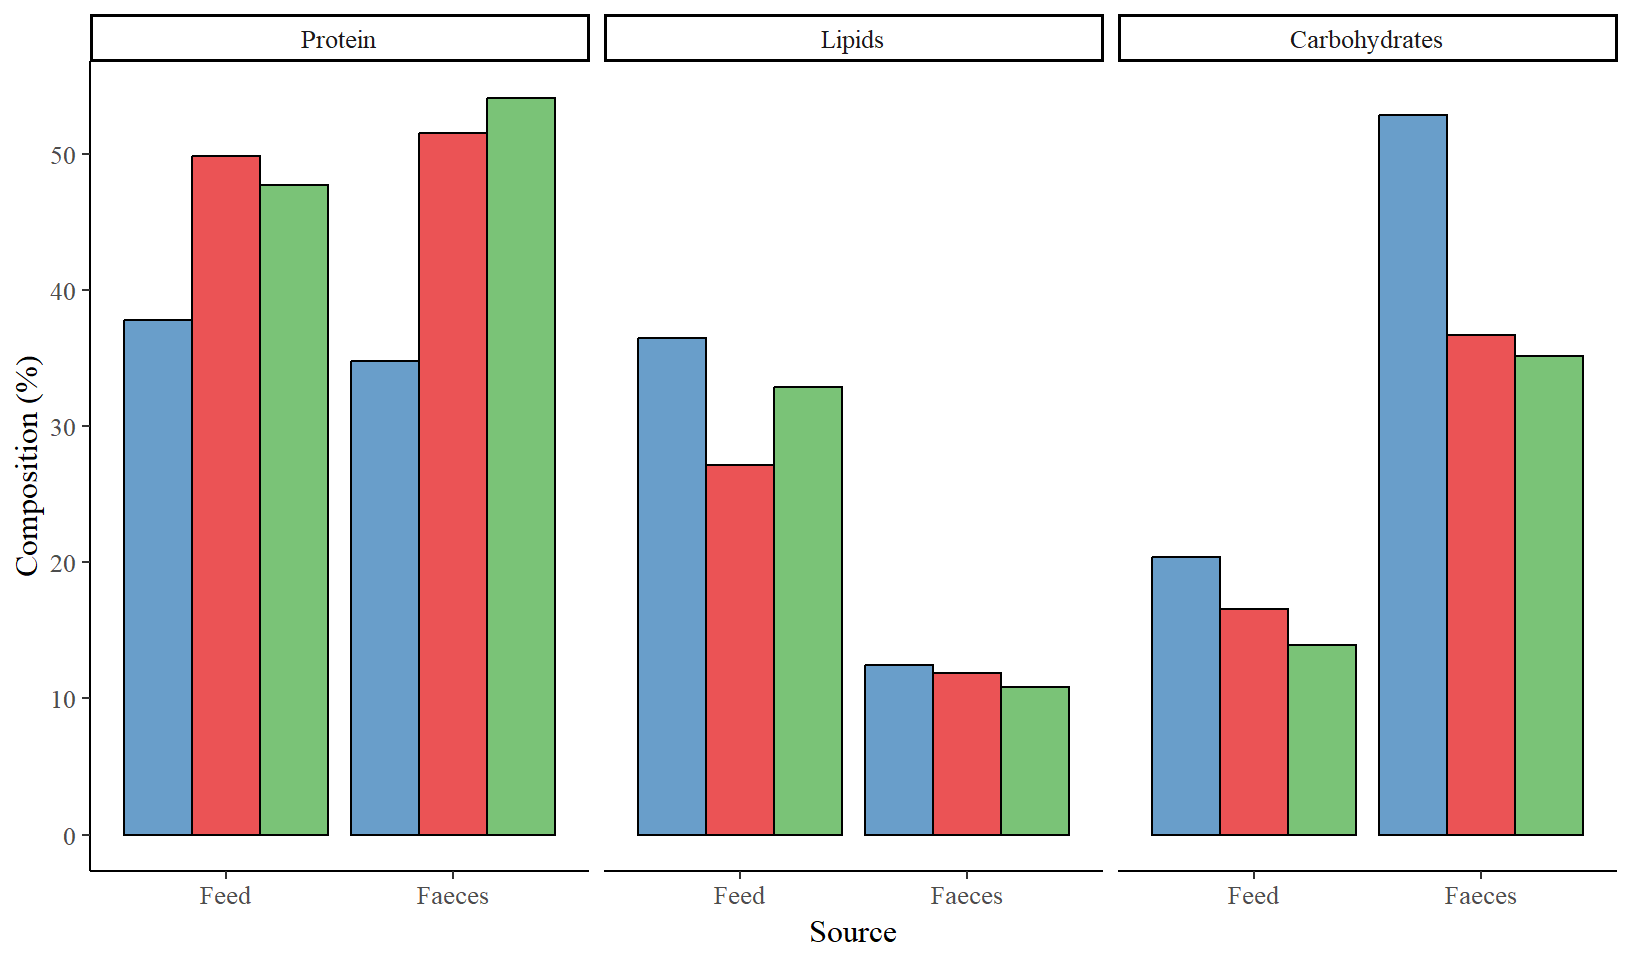

In [ ]:
ggplot(ec, aes(x = source, y = 100*value, fill = feed)) +
  geom_col(colour = "black", position = position_dodge(width = 0.9), alpha = 0.75) +
  facet_grid(cols = vars(macro)) +
  prettyplot() +
  scale_fill_manual(values = feed_pal) +
  scale_y_continuous(breaks = seq(0, 60, 10)) +
  labs(y = "Composition (%)", x = "Source")

## Total nutrients

# Statistical analysis & code availability

All analysis was conducted in R version 4.4.2 “Pile of Leaves” \[@R_base\]. Major packages used include `terra` \[@terra\], `targets` \[@targets\], `future` \[@future\], `furrr` \[@furrr\], `renv` \[@renv\], and the `tidyverse` \[@tidyverse\]. For a full list of R packages used see the lockfile on [Github](https://www.github.com). This manuscript was written in Quarto \[@quarto\] using TinyTex \[@tinytex\] and the acronyms extension \[@acronyms\].

# Supplementary stuff

## Parameter sensitivity

In [ ]:
sens_weight <- output_sens_data_path %>% 
  list.files(full.names = T) %>% 
  str_subset("results") %>% 
  str_subset("weight") %>% 
  qs::qread()

sens_excr <- output_sens_data_path %>% 
  list.files(full.names = T) %>% 
  str_subset("results") %>% 
  str_subset("total_excr") %>% 
  qs::qread() 

sens_data <- rbind(sens_weight, sens_excr) %>% 
  mutate(adj_param = factor(adj_param, levels = param_names$name))

Looking at @fig-param-sens-weight:

-   The most sensitive parameter by far is $m$ (the weight exponent for anabolism), followed closely by $n$ the (weight exponent for catabolism)
-   These two are also relatively uncertain, as $m$ was taken from *Salmo trutta* measurements in a fairly old paper \[@broekhuizen_modelling_1994\] and $n$ was taken from @baldan_r_2018 which did not specifically look at Atlantic salmon. There must be more up-to-date measurements for Atlantic salmon in particular.

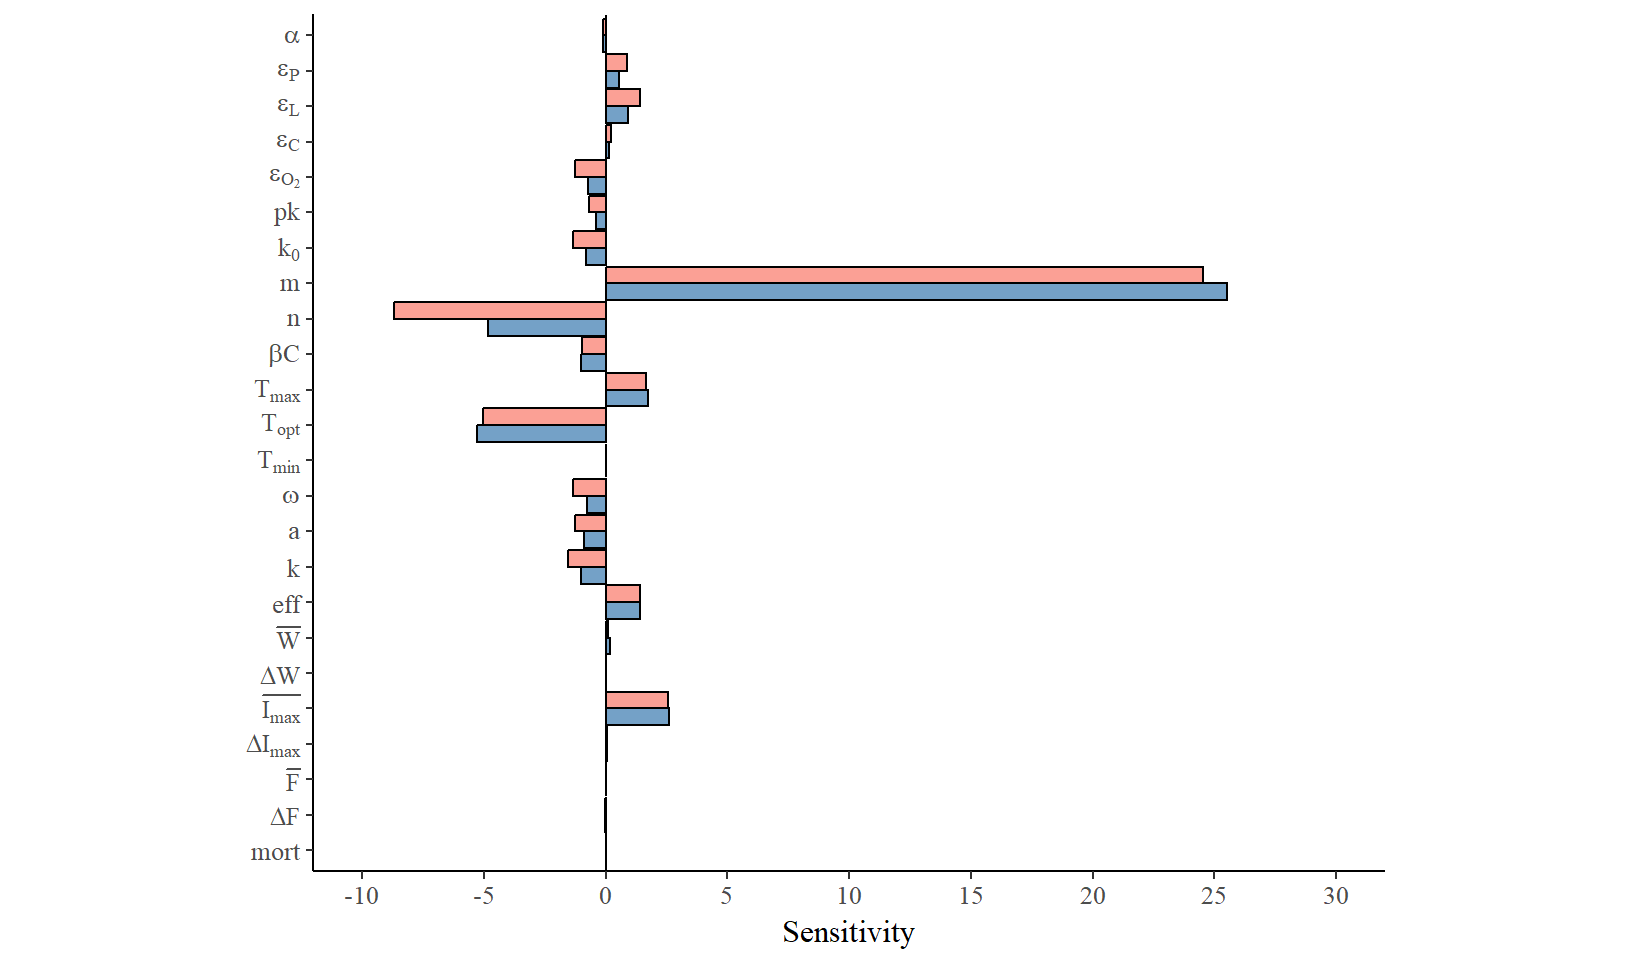

In [ ]:
sens_data %>% 
  ggplot(aes(x = adj_param, y = mean_sens, ymin = mean_sens - sd_sens, ymax = mean_sens + sd_sens, fill = measure)) +
  geom_col(position = position_dodge(), width = 0.95, colour = "black", alpha = 0.75) +
  # geom_errorbar(position = position_dodge(width = 0.95), width = 0.3) +
  geom_hline(aes(yintercept = 0), linetype = "dashed") +
  scale_y_continuous(breaks = seq(-30,30,5), limits = c(-10,30)) +
  scale_x_discrete(limits = rev(param_names$name), labels = rev(param_names$lab)) +
  scale_fill_manual(values = c(weight = "salmon", total_excr = "steelblue")) +
  # scale_fill_manual(values = c("weight" = "salmon", "uneat" = "steelblue", "excr" = "darkgreen")) +
  labs(x = "Adjusted parameter", y = "Sensitivity") +
  prettyplot() +
  theme(strip.text = element_blank(), 
        aspect.ratio = 0.8,
        axis.title.y = element_blank()) +
  coord_flip()

# References